# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 24**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Viktor Habony**  
**Neptun ID: H8SCMR** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
# ADD YOUR CODE HERE


from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode

from PIL import Image

import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import os
import cv2
import numpy as np
import random
import shutil
import seaborn as sns

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset


In [2]:
# ADD YOUR CODE HERE

download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [3]:
with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

#### Helper functions for:
 - get the image category
 - open images
 - denormalize images
 - show the image
 - display images with the grand truth mask (optinal: predicted mask)
 - preprocessing the grand truth mask
 - postprocessing the predicted mask

In [4]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
    
def denormalize(images, means, stds):
    
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
        
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds  = torch.tensor(stds).reshape(1, 3, 1, 1)
    
    return images * stds + means
    
def show_image(img_tensor):

    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)
    
def display_image_grid(orig_images, gt_masks, labels, images_num, predictions = None):
    
    cols = 3 if predictions is not None else 2
    rows = images_num
    
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    
    for i in range(images_num):

        gt_image       = convert_image(orig_images[i])
        gt_mask        = gt_masks[i]
        
        if predictions is not None:
            predicted_mask = predictions[i]
        
        ax[i, 0].imshow(gt_image)
        ax[i, 1].imshow(gt_mask, interpolation="nearest")

        ax[i, 0].set_title(labels[i])
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        
        if predictions is not None: 
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
        
    plt.tight_layout()
    plt.show()    
    
def convert_image(img_tensor):
    
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    
    return img_tensor

def preprocess_mask(mask):
    
    mask = mask.astype('uint8')
    mask[mask == 2] = 0
    mask[(mask == 1) | (mask == 3)] = 1
    
    return mask

def postprocess_predictions(predictions):
    
    for i in range(predictions.shape[0]):
    
        predictions[i] = predictions[i].astype('uint8')
        predictions[i][(predictions[i] != 12) & (predictions[i] != 8)] = 0
        predictions[i][(predictions[i] == 12) | (predictions[i] == 8)] = 1
        
    #predictions = torch.from_numpy(predictions)
    
    return predictions    

#### Class for the dataset loader

In [5]:
class PetsDataset(Dataset):
    
    def __init__(self, train_data, test_data, root, trimap_root, transform, size):
        
        super().__init__()
        
        self.train_data       = train_data
        self.test_data        = test_data
        self.directories      = [train_data, test_data]
        self.root             = root
        self.trimap_root      = trimap_root
        self.files            = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.test_images      = []
        self.test_images_path = []
        self.classes          = list(set(parse_breed(fname) for fname in self.files))
        self.transform        = transform
        self.size             = size
        
        # Creating subfolders for the classes 
        for directory in self.directories:
            for current_class in self.classes:
                if(not os.path.exists(os.path.join(directory, current_class))):
                    os.makedirs(os.path.join(directory, current_class))
        
                
        i = 0

        # Copying all images to the train folder    
        for img in self.files:

            img_class  = parse_breed(img)
            
            s = shutil.copy(self.root + '/' + img, self.train_data + '/' + img_class + '/')

            if len(s) != 0:
                i += 1
                print("Copying the " + str(i) + ". image to the " + self.train_data + '/' + img_class + " directory")  
            else:
                print("Something went wrong with the " + self.root + '/' + img + ' image')
        
                
        cnt = 0

        # Copying 20% of the images to the test folder
        for current_class in self.classes:
            for img in os.listdir(self.train_data + '/' + current_class):

                length = int(len(os.listdir(self.train_data + '/' + current_class)) * 0.2)

                if cnt < length:
                    shutil.move(self.train_data + '/' + current_class + '/' + img, self.test_data + '/' + current_class + '/')
                    self.test_images.append(img)
                    self.test_images_path.append(self.test_data + '/' + current_class)
                    cnt += 1
            cnt = 0    
            
        # Creating subfolders for the classes 
        for directory in self.directories:
            for current_class in self.classes:
                if(os.path.exists(os.path.join(directory, current_class))):
                    os.makedirs(os.path.join(directory, current_class, 'trimaps'))    
                    
        for current_class in self.classes:
            trimaps_for_class = [fname for fname in os.listdir(self.test_data + '/' + current_class) if fname.endswith('.jpg')]
            
            for img in trimaps_for_class:
                
                
                s = shutil.copy(self.trimap_root + '/' + img[:-4] + '.png', self.test_data + '/' + current_class + '/trimaps/')

                if len(s) != 0:
                    i += 1
                    print("Copying the " + str(i) + ". image to the " + self.test_data + '/' + current_class + ' /trimaps' + 'directory')  
                else:
                    print("Something went wrong with the " + self.test_data + '/' + img + ' image')
                    
    
    def __len__(self):
        return len(self.test_images)

    def __getitem__(self, i):
        fname           = self.test_images[i]
        fpath           = self.test_images_path[i] #os.path.join(self.root, fname)
        img             = self.transform(open_image(fpath + '/' + fname))
        trimap_new_path = fpath + '/trimaps'
        trimap_img      = preprocess_mask(cv2.imread(os.path.join(trimap_new_path, fname.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED))
        trimap_img      = cv2.resize(trimap_img, (self.size, self.size))
        class_name      = parse_breed(fname)
        
        return img, trimap_img, class_name

#### Creating and pre-processing the dataset

In [6]:
# ADD YOUR CODE HERE


train_data     = './data/oxford-iiit-pet/train'
test_data      = './data/oxford-iiit-pet/test'
images_dir     = './data/oxford-iiit-pet/images'
trimap_dir     = './data/oxford-iiit-pet/annotations/trimaps'
img_size       = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

images_transformer = T.Compose([T.Resize([img_size, img_size]), 
                                #T.Pad(8, padding_mode='reflect'),
                                #T.RandomCrop(img_size), 
                                T.ToTensor(), 
                                T.Normalize(*imagenet_stats)])


test_data = PetsDataset(train_data, test_data, images_dir, trimap_dir, images_transformer, 224)

Copying the 1. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 2. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 3. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 4. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 5. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 6. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 7. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 8. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 9. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 10. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 11. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 12. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 13. image to the ./data/oxford-iiit-pet/train/Aby

Copying the 137. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 138. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 139. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 140. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 141. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 142. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 143. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 144. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 145. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 146. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 147. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 148. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 149. image to the ./data/oxf

Copying the 268. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 269. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 270. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 271. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 272. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 273. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 274. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 275. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 276. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 277. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 278. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 279. image to the ./data/oxford-iiit-pet/t

Copying the 374. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 375. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 376. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 377. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 378. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 379. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 380. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 381. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 382. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 383. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 384. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 385. image to the ./data/oxford-iiit-pet/t

Copying the 490. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 491. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 492. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 493. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 494. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 495. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 496. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 497. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 498. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 499. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 500. image to the ./data/oxford-iiit-p

Copying the 595. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 596. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 597. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 598. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 599. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 600. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 601. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 602. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 603. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 604. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 605. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 606. ima

Copying the 734. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 735. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 736. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 737. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 738. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 739. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 740. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 741. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 742. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 743. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 744. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 745. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 746.

Copying the 871. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 872. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 873. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 874. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 875. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 876. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 877. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 878. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 879. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 880. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 881. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 882. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 883. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 

Copying the 1014. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1015. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1016. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1017. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1018. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1019. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1020. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1021. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1022. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1023. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1024. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1025. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1026. image to the ./data/oxford-iiit-pet/train/Bengal directory

Copying the 1151. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1152. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1153. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1154. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1155. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1156. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1157. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1158. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1159. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1160. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1161. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1162. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1163. image to the ./data/oxford-iiit-pet/train/Bengal directory

Copying the 1271. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1272. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1273. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1274. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1275. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1276. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1277. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1278. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1279. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1280. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1281. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1282. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1283. image to the ./data/oxford-iiit-pet/train/Birman directory

Copying the 1378. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1379. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1380. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1381. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1382. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1383. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1384. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1385. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1386. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1387. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1388. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1389. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1390. image to the ./data/oxford-iiit-pet/train/Birman directory

Copying the 1521. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1522. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1523. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1524. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1525. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1526. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1527. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1528. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1529. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1530. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1531. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1532. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1533. image to the ./data/oxford-iiit-pet/train/Bombay directory

Copying the 1667. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1668. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1669. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1670. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1671. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1672. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1673. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1674. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1675. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1676. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1677. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1678. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1679. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 

Copying the 1811. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1812. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1813. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1814. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1815. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1816. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1817. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1818. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1819. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1820. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1821. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1822. image to the .

Copying the 1917. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1918. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1919. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1920. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1921. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1922. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1923. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1924. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1925. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1926. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1927. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1928. image to the .

Copying the 2015. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2016. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2017. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2018. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2019. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2020. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2021. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2022. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2023. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2024. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2025. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2026. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2027. image to the ./data/ox

Copying the 2118. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2119. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2120. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2121. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2122. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2123. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2124. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2125. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2126. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2127. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2128. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2129. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2130. image to the ./data/ox

Copying the 2259. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2260. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2261. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2262. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2263. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2264. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2265. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2266. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2267. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2268. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2269. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2270. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copy

Copying the 2374. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2375. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2376. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2377. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2378. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2379. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2380. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2381. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2382. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2383. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2384. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2385. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copy

Copying the 2490. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2491. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2492. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2493. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2494. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2495. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2496. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2497. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2498. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2499. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2500. image to the ./data/oxford-iiit-pet/train/english co

Copying the 2620. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2621. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2622. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2623. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2624. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2625. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2626. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2627. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2628. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2629. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2630. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2631. image to the ./data/oxford-iiit-pet/train/engli

Copying the 2745. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2746. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2747. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2748. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2749. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2750. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2751. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2752. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2753. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2754. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2755. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2756. image to the ./data/oxford-iiit-pet/train/engli

Copying the 2883. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2884. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2885. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2886. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2887. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2888. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2889. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2890. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2891. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2892. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2893. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2894. ima

Copying the 3004. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3005. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3006. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3007. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3008. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3009. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3010. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3011. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3012. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3013. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3014. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3015. image to the ./data/oxford-iiit-pet/train/great

Copying the 3127. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3128. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3129. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3130. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3131. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3132. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3133. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3134. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3135. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3136. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3137. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3138. image to the ./data/oxford-iiit-pet/train/great

Copying the 3246. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3247. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3248. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3249. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3250. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3251. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3252. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3253. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3254. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3255. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3256. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3257. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3258. image to the ./data/oxford-iiit-pe

Copying the 3373. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3374. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3375. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3376. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3377. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3378. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3379. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3380. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3381. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3382. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3383. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3384. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3385. image to the ./data/oxford-iiit-pe

Copying the 3499. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3500. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3501. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3502. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3503. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3504. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3505. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3506. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3507. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3508. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3509. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3510. image to the ./data/oxford-iiit-pet/train/japanese chin di

Copying the 3624. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3625. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3626. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3627. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3628. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3629. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3630. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3631. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3632. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3633. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3634. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3635. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3636. image to the ./data/oxford-iiit-pe

Copying the 3750. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3751. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3752. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3753. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3754. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3755. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3756. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3757. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3758. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3759. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3760. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3761. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3762. image to the ./data/oxford-iiit-pe

Copying the 3861. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3862. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3863. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3864. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3865. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3866. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3867. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3868. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3869. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3870. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3871. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3872. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3873. image to t

Copying the 3976. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3977. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3978. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3979. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3980. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3981. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3982. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3983. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3984. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3985. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3986. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3987. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3988. image to t

Copying the 4090. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4091. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4092. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4093. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4094. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4095. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4096. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4097. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4098. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4099. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4100. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4101. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4102. image to t

Copying the 4198. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4199. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4200. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4201. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4202. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4203. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4204. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4205. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4206. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4207. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4208. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4209. image to the ./data/oxford-

Copying the 4311. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4312. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4313. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4314. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4315. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4316. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4317. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4318. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4319. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4320. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4321. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4322. ima

Copying the 4430. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4431. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4432. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4433. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4434. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4435. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4436. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4437. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4438. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4439. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4440. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4441. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copy

Copying the 4550. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4551. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4552. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4553. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4554. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4555. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4556. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4557. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4558. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4559. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4560. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4561. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copy

Copying the 4662. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4663. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4664. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4665. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4666. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4667. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4668. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4669. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4670. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4671. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4672. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4673. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4674. image to the ./data/oxford-iiit-pet/train/Pers

Copying the 4802. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4803. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4804. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4805. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4806. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4807. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4808. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4809. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4810. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4811. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4812. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4813. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4814. image to t

Copying the 4927. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4928. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4929. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4930. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4931. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4932. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4933. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4934. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4935. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4936. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4937. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4938. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4939. image to t

Copying the 5057. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5058. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5059. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5060. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5061. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5062. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5063. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5064. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5065. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5066. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5067. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5068. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5069. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5070. image to the ./data/

Copying the 5178. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5179. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5180. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5181. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5182. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5183. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5184. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5185. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5186. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5187. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5188. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5189. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5190. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5191. image to the ./data/

Copying the 5294. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5295. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5296. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5297. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5298. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5299. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5300. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5301. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5302. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5303. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5304. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5305. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5306. image to the ./data/oxford-iiit-pet/train/Ragd

Copying the 5407. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5408. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5409. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5410. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5411. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5412. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5413. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5414. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5415. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5416. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5417. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5418. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copy

Copying the 5510. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5511. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5512. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5513. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5514. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5515. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5516. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5517. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5518. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5519. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5520. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5521. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copy

Copying the 5639. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5640. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5641. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5642. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5643. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5644. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5645. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5646. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5647. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5648. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5649. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5650. image to the ./data/oxford-iiit-pet/train/saint bernard di

Copying the 5743. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5744. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5745. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5746. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5747. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5748. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5749. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5750. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5751. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5752. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5753. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5754. image to the ./data/oxford-iiit-pet/train/saint bernard di

Copying the 5878. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5879. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5880. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5881. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5882. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5883. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5884. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5885. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5886. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5887. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5888. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5889. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5890. image to the ./data/oxford-iiit-pet/train/samo

Copying the 6003. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6004. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6005. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6006. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6007. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6008. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6009. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6010. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6011. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6012. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6013. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6014. image to the ./data/oxfor

Copying the 6132. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6133. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6134. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6135. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6136. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6137. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6138. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6139. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6140. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6141. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6142. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6143. image to the ./data/oxfor

Copying the 6248. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6249. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6250. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6251. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6252. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6253. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6254. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6255. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6256. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6257. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6258. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6259. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6260. image to the ./data/ox

Copying the 6357. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6358. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6359. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6360. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6361. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6362. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6363. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6364. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6365. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6366. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6367. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6368. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6369. image to the ./data/ox

Copying the 6491. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6492. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6493. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6494. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6495. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6496. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6497. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6498. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6499. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6500. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6501. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6502. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6503. image to the ./data/oxford-iiit-pet/train/Siam

Copying the 6616. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6617. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6618. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6619. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6620. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6621. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6622. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6623. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6624. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6625. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6626. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6627. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6628. image to the ./data/oxford-iiit-pet/train/Sphynx directory

Copying the 6734. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6735. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6736. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6737. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6738. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6739. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6740. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6741. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6742. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6743. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6744. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6745. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6746. image to the ./data/oxford-iiit-pet/train/Sphynx directory

Copying the 6841. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6842. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6843. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6844. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6845. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6846. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6847. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6848. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6849. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6850. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6851. image to the

Copying the 6964. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6965. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6966. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6967. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6968. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6969. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6970. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6971. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6972. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6973. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6974. image to the

Copying the 7074. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7075. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7076. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7077. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7078. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7079. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7080. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7081. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7082. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7083. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7084. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7085. image to the ./data/oxford-iiit-pet/

Copying the 7188. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7189. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7190. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7191. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7192. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7193. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7194. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7195. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7196. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7197. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7198. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7199. image to the ./data/

Copying the 7309. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7310. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7311. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7312. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7313. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7314. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7315. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7316. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7317. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7318. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7319. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7320. image to the .

Copying the 7428. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7429. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7430. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7431. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7432. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7433. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7434. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7435. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7436. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7437. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7438. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying th

Copying the 7534. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7535. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7536. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7537. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7538. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7539. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7540. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7541. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7542. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7543. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying the 7544. image to the ./data/oxford-iiit-pet/test/Egyptian Mau /trimapsdirectory
Copying th

Copying the 7636. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7637. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7638. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7639. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7640. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7641. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7642. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7643. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7644. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7645. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 7646. image to the ./data/oxford-iiit-pet/test/great pyrenees /trima

Copying the 7750. image to the ./data/oxford-iiit-pet/test/yorkshire terrier /trimapsdirectory
Copying the 7751. image to the ./data/oxford-iiit-pet/test/yorkshire terrier /trimapsdirectory
Copying the 7752. image to the ./data/oxford-iiit-pet/test/yorkshire terrier /trimapsdirectory
Copying the 7753. image to the ./data/oxford-iiit-pet/test/yorkshire terrier /trimapsdirectory
Copying the 7754. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7755. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7756. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7757. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7758. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7759. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7760. image to the ./data/oxford-iiit-pet/test/Sphynx /trimapsdirectory
Copying the 7761. image to the .

Copying the 7848. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 7849. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 7850. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 7851. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 7852. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 7853. image to the ./data/oxford-iiit-pet/test/beagle /trimapsdirectory
Copying the 7854. image to the ./data/oxford-iiit-pet/test/beagle /trimapsdirectory
Copying the 7855. image to the ./data/oxford-iiit-pet/test/beagle /trimapsdirectory
Copying the 7856. image to the ./data/oxford-iiit-pet/test/beagle /trimapsdirectory
Copying the 7857. image to the ./data/oxford-iiit-pet/test/beagle /trimapsdirectory
Copying the 7858. image to the ./data/oxford-iiit-pet/test/beagle /trimapsdirectory
Copying the 7859. image to

Copying the 7952. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7953. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7954. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7955. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7956. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7957. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7958. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7959. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7960. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7961. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7962. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copying the 7963. image to the ./data/oxford-iiit-pet/test/boxer /trimapsdirectory
Copy

Copying the 8055. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8056. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8057. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8058. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8059. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8060. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8061. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8062. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8063. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8064. image to the ./data/oxford-iiit-pet/test/British Shorthair /trimapsdirectory
Copying the 8065. image to the ./data/oxford-iiit-

Copying the 8177. image to the ./data/oxford-iiit-pet/test/japanese chin /trimapsdirectory
Copying the 8178. image to the ./data/oxford-iiit-pet/test/japanese chin /trimapsdirectory
Copying the 8179. image to the ./data/oxford-iiit-pet/test/japanese chin /trimapsdirectory
Copying the 8180. image to the ./data/oxford-iiit-pet/test/japanese chin /trimapsdirectory
Copying the 8181. image to the ./data/oxford-iiit-pet/test/japanese chin /trimapsdirectory
Copying the 8182. image to the ./data/oxford-iiit-pet/test/japanese chin /trimapsdirectory
Copying the 8183. image to the ./data/oxford-iiit-pet/test/Russian Blue /trimapsdirectory
Copying the 8184. image to the ./data/oxford-iiit-pet/test/Russian Blue /trimapsdirectory
Copying the 8185. image to the ./data/oxford-iiit-pet/test/Russian Blue /trimapsdirectory
Copying the 8186. image to the ./data/oxford-iiit-pet/test/Russian Blue /trimapsdirectory
Copying the 8187. image to the ./data/oxford-iiit-pet/test/Russian Blue /trimapsdirectory
Copy

Copying the 8280. image to the ./data/oxford-iiit-pet/test/havanese /trimapsdirectory
Copying the 8281. image to the ./data/oxford-iiit-pet/test/havanese /trimapsdirectory
Copying the 8282. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8283. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8284. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8285. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8286. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8287. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8288. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8289. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirect

Copying the 8392. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8393. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8394. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8395. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8396. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8397. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8398. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8399. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8400. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8401. image to the ./data/oxford-iiit-pet/test/scottish terrier /trimapsdirectory
Copying the 8402. image to the ./data/oxford-iiit-pet/test/s

Copying the 8490. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8491. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8492. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8493. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8494. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8495. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8496. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8497. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8498. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8499. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8500. image to the ./data/oxford-iiit-pet/test/pomeranian /trimapsdirectory
Copying the 8501. image to the .

Copying the 8599. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8600. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8601. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8602. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8603. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8604. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8605. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8606. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8607. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8608. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8609. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory
Copying the 8610. image to the ./data/oxford-iiit-pet/test/pug /trimapsdirectory


In [7]:
len(test_data.test_images)

1220

#### Sample images and labels

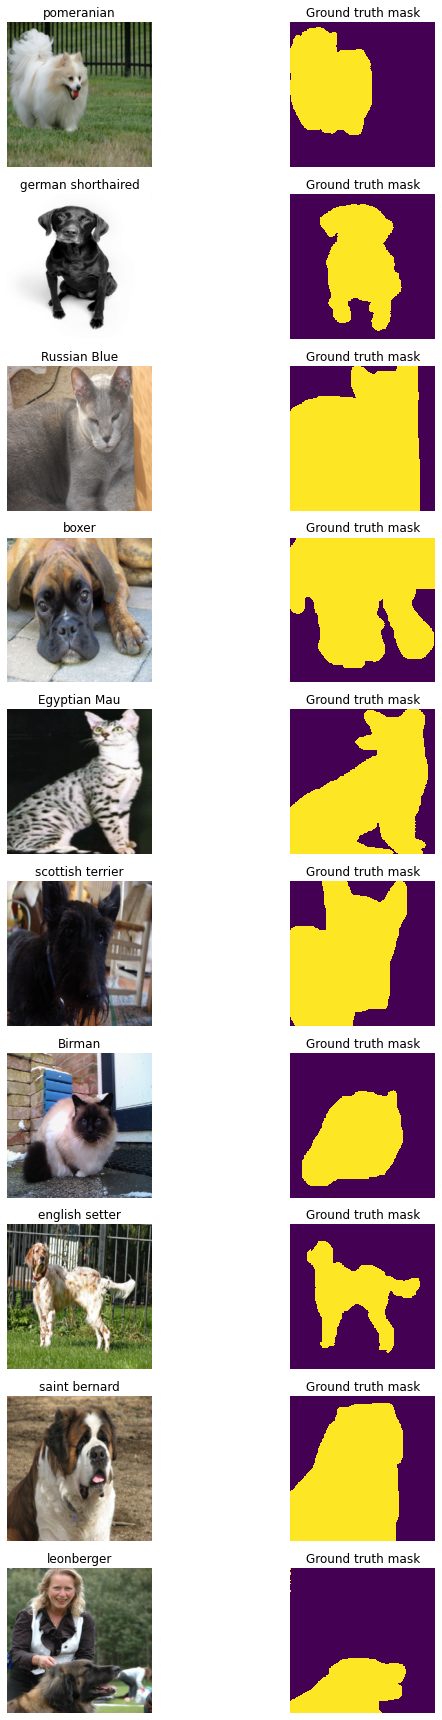

In [8]:
sample_loader = DataLoader(test_data, batch_size = 10, shuffle = True)
images, masks, labels = next(iter(sample_loader))

display_image_grid(images, masks, labels, 10)

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

#### Define functions for device and model loading:

 - FCN ResNet50
 - FCN ResNet101
 - DeepLabV3 ResNet101
 - LR-ASPP MobileNetV3-Large

In [9]:
# Device
def get_device():
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    return device

def get_fcn_resnet50():
    return models.segmentation.fcn_resnet50(pretrained=True).to(get_device())

def get_fcn_resnet101():
    return models.segmentation.fcn_resnet101(pretrained=True).to(get_device())

def get_lraspp_mobilenet_v3_large():
    return models.segmentation.lraspp_mobilenet_v3_large(pretrained=True).to(get_device())

def get_deeplabv3_resnet101():  
    return models.segmentation.deeplabv3_resnet101(pretrained=True).to(get_device())

### Question 1
Describe the main differences between the models you chose.



We have 4 models:
 - 2 model is a fully convolutional network. One has a 50 layers backbone, another has 101 layers backbone. Both has an FCNHead classifier.
 - LR-ASSP has a MobileNetV3-large backbone, which is 27% faster than V2, and a LRASPPHead classifier.
 - DeepLabV3 has a ResNet101 backbone and a DeepLabHead classifier which use atrous convolution operation in the layers.

#### Load the models
Show the architectures

In [10]:
# ADD YOUR CODE HERE

fcn_resnet50              = get_fcn_resnet50()
fcn_resnet101             = get_fcn_resnet101()
lraspp_mobilenet_v3_large = get_lraspp_mobilenet_v3_large()
deeplabv3_resnet101       = get_deeplabv3_resnet101()

ResNet50 architecture

In [11]:
print(fcn_resnet50)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

ResNet101 architecture

In [12]:
print(fcn_resnet101)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

DeepLabV3 ResNet101 arcitecture

In [13]:
print(deeplabv3_resnet101)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

LR-AASP architecture

In [14]:
print(lraspp_mobilenet_v3_large)

LRASPP(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

**Implement your metrics manually**. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

The dataset contains pixel-level trimap segmentation. For each image, there is an associated PNG file with a mask. The size of a mask equals to the size of the related image. Each pixel in a mask image can take one of three values: 1, 2, or 3. 1 means that this pixel of an image belongs to the class pet, 2 - to the class background, 3 - to the class border. Since we want binary segmentation (that is assigning one of two classes to each pixel), we will preprocess the mask, so it will contain only two uniques values: 0 if a pixel is a background and 1 if a pixel is a pet or a border.

#### Function for predictions

In [15]:
def get_predictions(test_data, model):
    
    device = get_device()
    model  = model
    
    images_tensors = []
    gt_tensors     = []
    output_tensors = []
    test_labels    = []

    test_loader = DataLoader(test_data, batch_size = 150, shuffle = False)

    model.eval()
    for i, (images, masks, labels) in enumerate(test_loader):
        images = images.to(device)

        # Make the predictions for labels across the image
        with torch.no_grad():
            output = model(images)["out"]
            output = output.argmax(1)

        output   = output.cpu().numpy()
        
        images_tensors.append(images.cpu().numpy())
        gt_tensors.append(masks.numpy())
        output_tensors.append(output)
        test_labels.append(labels)
        
    images      = np.concatenate([images_tensors[0], images_tensors[1]], axis = 0)
    predictions = np.concatenate([output_tensors[0], output_tensors[1]], axis = 0)
    gt_masks    = np.concatenate([gt_tensors[0], gt_tensors[1]], axis = 0)
    test_labs   = np.concatenate([test_labels[0], test_labels[1]], axis = 0)

    for i in range(len(output_tensors)):
        
        images      = np.concatenate([images, images_tensors[i]], axis = 0)
        predictions = np.concatenate([predictions, output_tensors[i]], axis = 0)
        gt_masks    = np.concatenate([gt_masks, gt_tensors[i]], axis = 0)
        test_labs    = np.concatenate([test_labs, test_labels[i]], axis = 0)

        
    return images, gt_masks, predictions, test_labs

#### Function for metrics:
 The selected metrics are the following:
  - accuracy
  - recall
  - Dice score
  - IoU
  - Mean Dice score
  - Mean IoU score

In [16]:
def metrics(gt_masks, predictions):
    
    accuracies = []
    recalls    = []
    mean_Dice  = []
    mean_IoU   = []

    for i in range(predictions.shape[0]):

        Y_pred = predictions[i]
        Y_true = gt_masks[i]

        FP = len(np.where(Y_pred - Y_true == -1)[0])
        FN = len(np.where(Y_pred - Y_true == 1)[0])
        TP = len(np.where(Y_pred + Y_true == 2)[0])
        TN = len(np.where(Y_pred + Y_true == 0)[0])

        cmat = [[TP, FN],
                [FP, TN]]

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        recall   = TP / (TP + FN + 1e-8)
        IoU      = TP / (TP + FP + FN)
        Dice     = (2 * TP) / (2 * TP + FP + FN)

        accuracies.append(accuracy)
        recalls.append(recall)
        mean_Dice.append(Dice)
        mean_IoU.append(IoU)
        
    accuracies = np.mean(np.array(accuracies))
    recalls    = np.mean(np.array(recalls))
    mean_Dice  = np.mean(np.array(mean_Dice))
    mean_IoU   = np.mean(np.array(mean_IoU))
    
    return accuracies, recalls, mean_Dice, mean_IoU

def dice_iou_new(gt_masks, predictions):
    
    num    = predictions.shape[0]
    inputs = predictions.reshape(num, -1)
    target = gt_masks.reshape(num, -1)

    intersection = (inputs * target).sum(1)
    union        = inputs.sum(1) + target.sum(1)
    dice         = (2. * intersection) / (union + 1e-8)
    dice         = dice.sum() / num
    IoU          = (intersection) / (union - intersection)
    IoU          = IoU.sum() / num

    print("Dice", dice)
    print("mean_IoU", IoU)
    
def show_confusion_mat(cmat):
    
    plt.figure(figsize = (6,6))
    sns.heatmap(cmat / np.sum(cmat), cmap = "Reds", annot = True, fmt = '.2%', square = 1,   linewidth = 2.)
    plt.xlabel("predictions")
    plt.ylabel("real values")
    plt.show()

### FCN ResNet50

#### Get the predictions for the mask and post-processing them:
 - Convert the categories from 8 and 12 (cat and dog category in the original model) to 0 and 1

In [17]:
# ADD YOUR CODE HERE

resnet50_images, resnet50_gt_masks, resnet50_predictions, resnet50_test_labels = get_predictions(test_data, fcn_resnet50)
resnet50_predictions                                                           = postprocess_predictions(resnet50_predictions)

print(resnet50_images.shape)
print(resnet50_gt_masks.shape)
print(resnet50_predictions.shape)
print(resnet50_test_labels.shape)

(1520, 3, 224, 224)
(1520, 224, 224)
(1520, 224, 224)
(1520,)


#### Show the metrics results

In [18]:
# ADD YOUR CODE HERE

resnet50_accuracies, resnet50_recalls, resnet50_mean_Dice, resnet50_mean_IoU = metrics(resnet50_gt_masks, resnet50_predictions)

print(f'ResNet50: Accuracy- {resnet50_accuracies * 100}, Recall- {resnet50_recalls * 100}, Mean Dice- {resnet50_mean_Dice * 100}, Mean IoU- {resnet50_mean_IoU * 100}')

ResNet50: Accuracy- 92.46757990819683, Recall- 97.08270559334031, Mean Dice- 87.1096852357295, Mean IoU- 79.41316322156405


### FCN ResNet100

In [19]:
resnet101_images, resnet101_gt_masks, resnet101_predictions, resnet101_test_labels = get_predictions(test_data, fcn_resnet101)
resnet101_predictions                                                              = postprocess_predictions(resnet101_predictions)

In [20]:
resnet101_accuracies, resnet101_recalls, resnet101_mean_Dice, resnet101_mean_IoU = metrics(resnet101_gt_masks, resnet101_predictions)

print(f'ResNet100: Accuracy- {resnet101_accuracies * 100}, Recall- {resnet101_recalls * 100}, Mean Dice- {resnet101_mean_Dice * 100}, Mean IoU- {resnet101_mean_IoU * 100}')

ResNet100: Accuracy- 93.09694874043367, Recall- 97.31104275212672, Mean Dice- 88.18816432832313, Mean IoU- 80.79855255317145


### DeepLabV3

In [ ]:
deeplabv3_images, deeplabv3_gt_masks, deeplabv3_predictions, deeplabv3_test_labels = get_predictions(test_data, deeplabv3_resnet101)
deeplabv3_predictions                                                              = postprocess_predictions(deeplabv3_predictions)

In [ ]:
deeplabv3_accuracies, deeplabv3_recalls, deeplabv3_mean_Dice, deeplabv3_mean_IoU = metrics(deeplabv3_gt_masks, deeplabv3_predictions)

print(f'DeepLabV3: Accuracy- {deeplabv3_accuracies * 100}, Recall- {deeplabv3_recalls * 100}, Mean Dice- {deeplabv3_mean_Dice * 100}, Mean IoU- {deeplabv3_mean_IoU * 100}')

### LR-AASP

In [ ]:
lr_aasp_images, lr_aasp_gt_masks, lr_aasp_predictions, lr_aasp_test_labels = get_predictions(test_data, lraspp_mobilenet_v3_large)
lr_aasp_predictions                                                        = postprocess_predictions(lr_aasp_predictions)

In [ ]:
lr_aasp_accuracies, lr_aasp_recalls, lr_aasp_mean_Dice, lr_aasp_mean_IoU = metrics(lr_aasp_gt_masks, lr_aasp_predictions)

print(f'LR-AASP: Accuracy- {lr_aasp_accuracies * 100}, Recall- {lr_aasp_recalls * 100}, Mean Dice- {lr_aasp_mean_Dice * 100}, Mean IoU- {lr_aasp_mean_IoU * 100}')

In [ ]:
print(resnet101_accuracies * 100 - resnet50_accuracies * 100)
print(resnet101_recalls * 100 - resnet50_recalls * 100)
print(resnet101_mean_Dice * 100 - resnet50_mean_Dice * 100)
print(resnet101_mean_IoU * 100 - resnet50_mean_IoU * 100)

#### Displaying the metrics results

In [ ]:

# Define Data
plt.rcParams["figure.figsize"] = (20,8)

models     = ['FCN ResNet50','FCN ResNet101','DeepLabV3','LR-AASP']
model_acc  = [resnet50_accuracies * 100, resnet101_accuracies * 100, deeplabv3_accuracies * 100, lr_aasp_accuracies * 100]
model_rec  = [resnet50_recalls * 100, resnet101_recalls * 100, deeplabv3_recalls * 100, lr_aasp_recalls * 100]
model_dice = [resnet50_mean_Dice * 100, resnet101_mean_Dice * 100, deeplabv3_mean_Dice * 100, lr_aasp_mean_Dice * 100]
model_iou  = [resnet50_mean_IoU * 100, resnet101_mean_IoU * 100, deeplabv3_mean_IoU * 100, lr_aasp_mean_IoU * 100]


x_axis = np.arange(len(models))

# Multi bar Chart

plt.bar(x_axis -0.2, model_acc, width=0.2, label = 'Accuracy')
plt.bar(x_axis +0.0, model_rec, width=0.2, label = 'Recall')
plt.bar(x_axis +0.2, model_dice, width=0.2, label = 'Mean Dice')
plt.bar(x_axis +0.4, model_iou, width=0.2, label = 'Mean IoU')

# Xticks
plt.xticks(x_axis, models)

# Add legend
plt.legend()

# Display
plt.show()

#### Show some predictions

Original resized image - Grand truth mask - Predicted mask

In [ ]:
# ADD YOUR CODE HERE

display_image_grid(torch.from_numpy(deeplabv3_images),
                   deeplabv3_gt_masks,
                   deeplabv3_test_labels,
                   20,
                   deeplabv3_predictions)

## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

#### Question 3. 
How could you improve the performance of the models?

Question 2:

The most relevant metrics are Mean Dice and Mean IoU. The best model was FCN ResNet101. The second best was FCN ResNet50. You can see the differences to ResNet50 below:

Accuracy: 0.3728769468313544
Recall: -0.11780934898256135
Mean Dice: 0.5074912314935744
Mean IoU:0.7437575994871537

Maybe the reason for that is ResNet101 has more layers.

Question 3.:

Because these are pre-trained models and they have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset, therefore in order to get a better model we have to use transfer learning and fine-tuning the model on the current dataset.